---

<div id="Importing_Libraries">
    
# **Importing Libraries** 

In [ ]:
# !pip install -q mediapipe==0.10.7

In [1]:
import os
import gc
import cv2
import json
import time
import shutil
import numpy as np
from tqdm import tqdm
import mediapipe as mp
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from concurrent.futures import ThreadPoolExecutor
from IPython.display import clear_output, FileLink
import keras

---

<div id="Data_Preparation">
    
# **Data Preparation**
**<h2>(Done Once)**

<h3> We first load the data

In [ ]:
with open('data/asl_words_video/WLASL_v0.3.json', 'r') as json_file:
    all_data = json.load(json_file)

<h3> Then we extract the needed information from the data
<h4>    
    
* gloss : the word being expressed
    
* video_path : the path to the video in the datasets
    
* frame_start : the frame number where the word starts
    
* frame_end : the frame number where each word ends
   
* split : the type of data when modeling (train, val, test)

In [ ]:
len(all_data)

In [ ]:
video_dir = 'data/asl_words_video/videos'
# backup_dir = '/kaggle/input/wlasl2000-resized/wlasl-complete/videos'
data = [] # formatted data

for i in tqdm(range(len(all_data)), ncols=100):
# for i in tqdm(range(10), ncols=100):    
    gloss = all_data[i]['gloss']
    instances = all_data[i]['instances']
    for instance in instances:
        video_id = instance['video_id']
        if os.path.exists(os.path.join(video_dir, f'{video_id}.mp4')):
            video_path = os.path.join(video_dir, f'{video_id}.mp4')
        # elif os.path.exists(os.path.join(backup_dir, f'{video_id}.mp4')):
            # video_path = os.path.join(backup_dir, f'{video_id}.mp4')
        else:
            continue
            
        frame_start = instance['frame_start']
        frame_end = instance['frame_end']
        split = instance['split']
        data.append({
            'gloss': gloss,
            'video_path': video_path,
            'frame_start': frame_start,
            'frame_end': frame_end,
            'split': split
        })

<h3> We then save the organized dictionary for future uses

In [ ]:
with open('data/asl_words_video/WLASL_parsed_data.json', 'w') as json_file:
    json.dump(data, json_file, indent=4)
    
FileLink(r'WLASL_parsed_data.json')

---

<div id="Label_Filtering">

# **Label Filtering**
**<h2>(Done Once)**

In [ ]:
with open('data/asl_words_video/WLASL_parsed_data.json', 'r') as json_file:
    data = json.load(json_file)

In [ ]:
list_labels = list()
for i in tqdm(range(len(data)), ncols=100):
    gloss = data[i]['gloss']
    list_labels.append(gloss)
# list_labels

In [ ]:
import fasttext
import fasttext.util
fasttext.util.download_model('en', if_exists='ignore')
ft = fasttext.load_model('cc.en.300.bin')

In [ ]:
labels = list(np.unique(list_labels))
len(labels)

In [ ]:
# with open('data/asl_words_video/filtered_labels.txt', 'w') as file:
#     for label in labels:
#         file.write(label + '\n')

In [ ]:
encoded_labels = {label: ft.get_word_vector(label) for label in labels}
np.savez_compressed('data/asl_words_video/labels.npz', **encoded_labels)

In [ ]:
def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

word1 = 'happy'
word2 = 'pleased'

vector1 = ft.get_word_vector(word1)
vector2 = ft.get_word_vector(word2)

similarity_score = cosine_similarity(vector1, vector2)
print(f"Similarity score between '{word1}' and '{word2}': {similarity_score}")

In [ ]:
labels_dict = np.load('data/asl_words_video/labels.npz', allow_pickle=True)

In [ ]:
word = 'car'
word_vector = ft.get_word_vector(word)

similarity_scores = []
for label, label_vector in labels_dict.items():
    similarity_scores.append(cosine_similarity(word_vector, label_vector))

In [ ]:
bins = np.linspace(0, 1, 21)

plt.hist(similarity_scores, bins=bins, edgecolor='black')
plt.title(f'Cosine Similarity Distribution to "{word}"')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.grid(axis='y')
plt.show()

In [ ]:
chosen_words = [
    'hello',
    'goodbye',
    'thank you',
    'sorry',
    'yes',
    'no',
    'stop',
    'go',
    'left',
    'right',
    'help',
]

In [ ]:
threshold = 0.6
similar_words_set = set()
popular_word_vectors = [ft.get_word_vector(word) for word in chosen_words]

for label, label_vector in labels_dict.items():
    for popular_word_vector in popular_word_vectors:
        similarity_score = cosine_similarity(popular_word_vector, label_vector)
        if similarity_score > threshold:
            similar_words_set.add(label)
            
similar_words_list = list(similar_words_set)

In [ ]:
len(similar_words_list)

In [ ]:
with open('data/asl_words_video/filtered_labels.txt', 'w') as file:
    for label in similar_words_list:
        file.write(label + '\n')

---

<div id="MediaPipe_Implementation">

# **MediaPipe Implementation**
**<h2>(Not important when training)**

<h3> We first choose the landmarks
<h4>    
    
* Hands : we'll keep all **42** of them, as they are the most important part.
    
* Pose : **6** landmarks for the upper body excluding the face, as we have dedicated process for it.
    
* Face : out of the **478** landmarks, we'll choose **132**, focusing on the lips, eyes, eyebrows, and the outline of the face.
    
* This brings the total number of landmarks to **180**, each with coordinates (x, y, z).   

In [84]:
filtered_hand = list(range(21))

filtered_pose = [11, 12, 13, 14, 15, 16]

filtered_face = [0, 4, 7, 8, 10, 13, 14, 17, 21, 33, 37, 39, 40, 46, 52, 53, 54, 55, 58,
                 61, 63, 65, 66, 67, 70, 78, 80, 81, 82, 84, 87, 88, 91, 93, 95, 103, 105,
                 107, 109, 127, 132, 133, 136, 144, 145, 146, 148, 149, 150, 152, 153, 154,
                 155, 157, 158, 159, 160, 161, 162, 163, 172, 173, 176, 178, 181, 185, 191,
                 234, 246, 249, 251, 263, 267, 269, 270, 276, 282, 283, 284, 285, 288, 291,
                 293, 295, 296, 297, 300, 308, 310, 311, 312, 314, 317, 318, 321, 323, 324,
                 332, 334, 336, 338, 356, 361, 362, 365, 373, 374, 375, 377, 378, 379, 380,
                 381, 382, 384, 385, 386, 387, 388, 389, 390, 397, 398, 400, 402, 405, 409,
                 415, 454, 466, 468, 473]

HAND_NUM = len(filtered_hand)
POSE_NUM = len(filtered_pose)
FACE_NUM = len(filtered_face)

<h3>Extracting landmarks from a frame

In [85]:
hands = mp.solutions.hands.Hands()
pose = mp.solutions.pose.Pose()
face_mesh = mp.solutions.face_mesh.FaceMesh(refine_landmarks=True)

def get_frame_landmarks(frame):
    
    all_landmarks = np.zeros((HAND_NUM * 2 + POSE_NUM + FACE_NUM, 3))
    
    def get_hands(frame):
        results_hands = hands.process(frame)
        if results_hands.multi_hand_landmarks:
            for i, hand_landmarks in enumerate(results_hands.multi_hand_landmarks):
                if results_hands.multi_handedness[i].classification[0].index == 0: 
                    all_landmarks[:HAND_NUM, :] = np.array(
                        [(lm.x, lm.y, lm.z) for lm in hand_landmarks.landmark]) # right
                else:
                    all_landmarks[HAND_NUM:HAND_NUM * 2, :] = np.array(
                        [(lm.x, lm.y, lm.z) for lm in hand_landmarks.landmark]) # left

    def get_pose(frame):
        results_pose = pose.process(frame)
        if results_pose.pose_landmarks:
            all_landmarks[HAND_NUM * 2:HAND_NUM * 2 + POSE_NUM, :] = np.array(
                [(lm.x, lm.y, lm.z) for lm in results_pose.pose_landmarks.landmark])[filtered_pose]
        
    def get_face(frame):
        results_face = face_mesh.process(frame)
        if results_face.multi_face_landmarks:
            all_landmarks[HAND_NUM * 2 + POSE_NUM:, :] = np.array(
                [(lm.x, lm.y, lm.z) for lm in results_face.multi_face_landmarks[0].landmark])[filtered_face]
        
    with ThreadPoolExecutor(max_workers=3) as executor:
        executor.submit(get_hands, frame)
        executor.submit(get_pose, frame)
        executor.submit(get_face, frame)

    return all_landmarks

I0000 00:00:1724821798.170108  308659 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M3 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1724821798.175872  416394 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1724821798.176254  308659 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M3 Pro
W0000 00:00:1724821798.179621  416394 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1724821798.183503  308659 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M3 Pro
W0000 00:00:1724821798.184779  416420 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


W0000 00:00:1724821798.189841  416423 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1724821798.235599  416407 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1724821798.239761  416411 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


<h3>Extracting landmarks from a video

In [86]:
def get_video_landmarks(video_path, start_frame=1, end_frame=-1):
    cap = cv2.VideoCapture(video_path)
    
    # if the starting is 0
    if start_frame <= 1:
        start_frame = 1
        
    # if the video is precropped
    elif start_frame > int(cap.get(cv2.CAP_PROP_FRAME_COUNT)):
        start_frame = 1
        end_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
    # if the final frame was not given (-1)    
    if end_frame < 0: 
        end_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    num_landmarks = HAND_NUM * 2 + POSE_NUM + FACE_NUM
    all_frame_landmarks = np.zeros((end_frame - start_frame + 1, num_landmarks, 3))
    frame_index = 1
    
    while cap.isOpened() and frame_index <= end_frame:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_index >= start_frame:
            frame.flags.writeable = False
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame_landmarks = get_frame_landmarks(frame)
            all_frame_landmarks[frame_index - start_frame] = frame_landmarks

        frame_index += 1

    cap.release()
    hands.reset()
    pose.reset()
    face_mesh.reset()
    return all_frame_landmarks

<h3>Drawing landmarks on a video

In [87]:
def draw_landmarks(input_path, output_path, video_landmarks, start_frame=1, end_frame=-1):
    cap = cv2.VideoCapture(input_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    if start_frame <= 1:
        start_frame = 1
    elif start_frame > int(cap.get(cv2.CAP_PROP_FRAME_COUNT)):
        start_frame = 1
        end_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if end_frame < 0:
        end_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
    frame_index = 1
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_index >= start_frame and frame_index <= end_frame:
            frame_landmarks = video_landmarks[frame_index - start_frame]
            landmarks = [(int(x * width), int(y * height)) for x, y, _ in frame_landmarks]
            for x, y in landmarks:
                cv2.circle(frame, (x, y), 3, (0, 0, 255), -1)
            out.write(frame)
        else:
            # out.write(frame) # Enable if you want the full video
            pass
        frame_index += 1

    cap.release()
    out.release()

---

<div id="Visualizing_Landmarks">

# **Visualizing Landmarks**
**<h2>(Not important when training)**

<h3>Test on a frame

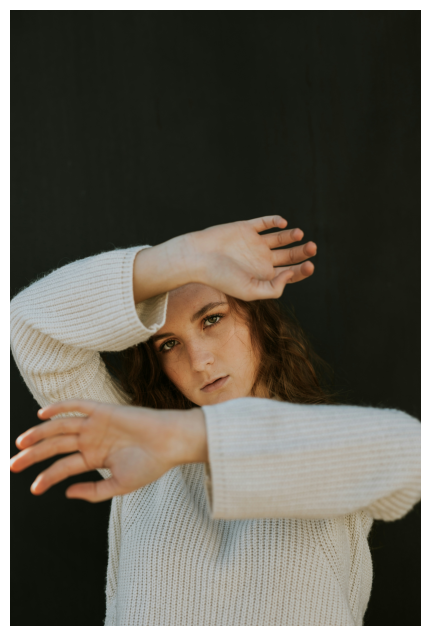

In [82]:
import requests
from PIL import Image
from io import BytesIO

image_url = 'https://images.unsplash.com/photo-1515294898968-a408405d7674'
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))
img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

plt.figure(figsize=(8, 8))
plt.imshow(img[:,:,::-1])
plt.axis('off')
plt.show()

/Users/hanhf/anaconda3/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


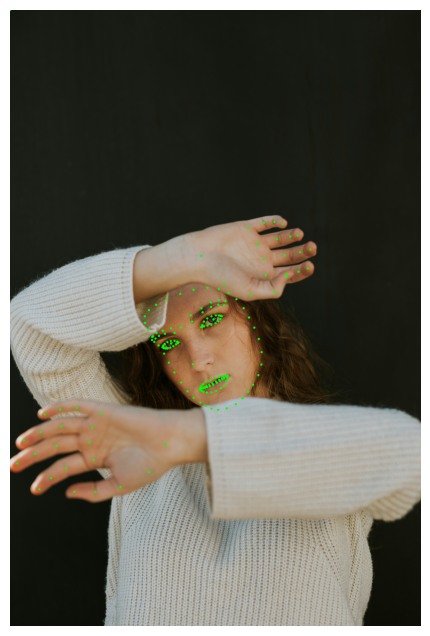

In [88]:
height, width, _ = img.shape

frame_landmarks = get_frame_landmarks(img[:,:,::-1])
for landmark in frame_landmarks:
    x = int(landmark[0] * width)
    y = int(landmark[1] * height)
    cv2.circle(img, (x, y), 10, (0, 255, 0), -1)

plt.figure(figsize=(8, 8))
plt.imshow(img[:,:,::-1])
plt.axis('off')
plt.show()

<h3> Test on video

In [89]:
with open('data/asl_words_video/WLASL_parsed_data.json', 'r') as json_file:
    data = json.load(json_file)
    
test = data[40]
video_landmarks = get_video_landmarks(test['video_path'],test['frame_start'],test['frame_end'])

output_path = 'landmarks_test.mp4'
draw_landmarks(test['video_path'], output_path, video_landmarks, test['frame_start'],test['frame_end'])

W0000 00:00:1724821818.769199  416390 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1724821818.772256  416430 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1724821818.772537  416393 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1724821818.775663  416426 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1724821818.828156  416417 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1724821818.833049  416416 inference_feedback_manager.cc:114] Feedback manager 

In [ ]:
# os.remove('/kaggle/working/landmarks_test.mp4')

---

<div id="Data_Encoding">
    
# **Data Encoding**
**<h2>(Done Once)**

In [ ]:
filtered_labels = []
with open('data/asl_words_video/filtered_labels.txt', 'r') as file:
    filtered_labels = file.read().splitlines()

In [ ]:
npy_dir = 'data/asl_words_video/landmarks'
os.makedirs(npy_dir, exist_ok=True)

In [ ]:
try:
    for i in tqdm(range(len(data)), ncols=100):
        npy_path = os.path.join(npy_dir, f'{i}.npy')
        if os.path.exists(npy_path): continue
        if data[i]['gloss'] not in filtered_labels: continue
        video_path = data[i]['video_path']
        start = data[i]['frame_start']
        end = data[i]['frame_end']
        
        try:
            video_landmarks = get_video_landmarks(video_path, start, end)
            np.save(npy_path, video_landmarks)
            
        except Exception as e:
            print(f"\nError encoding {video_path}\n{e}")
            continue   
        clear_output(wait=True)

except KeyboardInterrupt:
    print("\nLoading process interrupted by user.")

In [ ]:
landmarks_dict = {}

for filename in os.listdir(npy_dir):
    if filename.endswith('.npy'):
        key = filename.split('.')[0]
        landmarks = np.load(os.path.join(npy_dir, filename), allow_pickle=True)
        landmarks_dict[key] = landmarks

np.savez_compressed('data/asl_words_video/landmarks_V2.npz', **landmarks_dict)

FileLink(r'landmarks_V2.npz')

---

<div id="Data_Loading">
    
# **Data Loading**

In [9]:
landmarks_dict = np.load('data/asl_words_video/landmarks_V2.npz', allow_pickle=True)

In [10]:
labels_dict = np.load('data/asl_words_video/labels.npz', allow_pickle=True)

In [11]:
with open('data/asl_words_video/WLASL_parsed_data.json', 'r') as json_file:
    data = json.load(json_file)

<h3> Filter Labels

In [12]:
labels = []
with open('data/asl_words_video/filtered_labels.txt', 'r') as file:
    labels = file.read().splitlines()

<h3> Loading Function

In [13]:
def load_data(split, labels=None, max_labels=None, max_samples=None, landmarks=None, keys=None):
    
    if landmarks is None:
     #    landmarks = list(range(landmarks_dict['0'].shape[1]))
        landmarks = list(range(landmarks_dict['928'].shape[1]))
    
    if keys is None:
        keys = [k for k in landmarks_dict.keys()]
    
    if labels is not None:
        X = [landmarks_dict[k][:, landmarks, :] for k in keys
             if data[int(k)]['split'] == split and data[int(k)]['gloss'] in labels]
        Y = [data[int(k)]['gloss'] for k in keys
             if data[int(k)]['split'] == split and data[int(k)]['gloss'] in labels]
    
    elif max_samples is not None:
        X = [landmarks_dict[k][:, landmarks, :] for k in keys
             if data[int(k)]['split'] == split][:max_samples]
        Y = [data[int(k)]['gloss'] for k in keys
             if data[int(k)]['split'] == split][:max_samples]
    
    elif max_labels is not None:
        label_counts = {}
        for k in keys:
            label = data[int(k)]['gloss']
            label_counts[label] = label_counts.get(label, 0) + 1
        
        top_labels = sorted(label_counts, key=label_counts.get, reverse=True)[:max_labels]
        X = [landmarks_dict[k][:, landmarks, :] for k in keys
             if data[int(k)]['gloss'] in top_labels and data[int(k)]['split'] == split]
        Y = [data[int(k)]['gloss'] for k in keys
             if data[int(k)]['gloss'] in top_labels and data[int(k)]['split'] == split]
        
    else:
        X = [landmarks_dict[k][:, landmarks, :] for k in keys
             if data[int(k)]['split'] == split]
        Y = [data[int(k)]['gloss'] for k in keys
             if data[int(k)]['split'] == split]
    
    return X, Y

In [14]:
X_train, Y_train = load_data('train', labels=labels)
X_val, Y_val = load_data('val', labels=labels)
X_test, Y_test = load_data('test', labels=labels)

In [15]:
len(X_train), len(X_val), len(X_test)

(92, 23, 17)

In [16]:
X_train[0].shape

(83, 180, 3)

In [17]:
len(np.unique(Y_train)), len(np.unique(Y_val)), len(np.unique(Y_test))

(18, 16, 12)

In [18]:
np.all(np.in1d(np.unique(Y_val), np.unique(Y_train))),\
np.all(np.in1d(np.unique(Y_test), np.unique(Y_train)))

(True, True)

In [19]:
# free space
del landmarks_dict, data
gc.collect()

5952

---

<div id="Data_Augmentation">
    
# **Data Augmentation**

<h3> Rotation Augmentations

In [20]:
def rotate(data, rotation_matrix):
    frames, landmarks, _ = data.shape
    center = np.array([0.5, 0.5, 0])
    non_zero = np.argwhere(np.any(data[:, :, :2] != 0, axis=2))
    data = data.reshape(-1, 3)
    data[non_zero] -= center
    data[non_zero] = np.dot(data[non_zero], rotation_matrix.T)
    data[non_zero] += center
    data = data.reshape(frames, landmarks, 3)
    out_of_range = np.any((data[:, :, :2] < 0) | (data[:, :, :2] > 1), axis=2)
    data[out_of_range] = 0
    return data

def rotate_z(data):
    angle = np.random.choice([np.random.uniform(-30, -10),
                              np.random.uniform(10, 30)])
    theta = np.radians(angle)
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta), np.cos(theta), 0],
        [0, 0, 1]
    ])
    return rotate(data, rotation_matrix)

def rotate_y(data):
    angle = np.random.choice([np.random.uniform(-30, -10),
                              np.random.uniform(10, 30)])
    theta = np.radians(angle)
    rotation_matrix = np.array([
        [np.cos(theta), 0, np.sin(theta)],
        [0, 1, 0],
        [-np.sin(theta), 0, np.cos(theta)]
    ])
    return rotate(data, rotation_matrix)

def rotate_x(data):
    angle = np.random.choice([np.random.uniform(-30, -10),
                              np.random.uniform(10, 30)])
    theta = np.radians(angle)
    rotation_matrix = np.array([
        [1, 0, 0],
        [0, np.cos(theta), -np.sin(theta)],
        [0, np.sin(theta), np.cos(theta)]
    ])
    return rotate(data, rotation_matrix)

<h3> Other Augmentations

In [21]:
def zoom(data):
    factor = np.random.uniform(0.8, 1.2)
    center = np.array([0.5, 0.5])
    non_zero = np.argwhere(np.any(data[:, :, :2] != 0, axis=2))
    data[non_zero[:, 0], non_zero[:, 1], :2] = (
        (data[non_zero[:, 0], non_zero[:, 1], :2] - center) * factor + center
    )
    out_of_range = np.any((data[:, :, :2] < 0) | (data[:, :, :2] > 1), axis=2)
    data[out_of_range] = 0
    return data

def shift(data):
    x_shift = np.random.uniform(-0.2, 0.2)
    y_shift = np.random.uniform(-0.2, 0.2)
    non_zero = np.argwhere(np.any(data[:, :, :2] != 0, axis=2))
    data[non_zero[:, 0], non_zero[:, 1], 0] += x_shift
    data[non_zero[:, 0], non_zero[:, 1], 1] += y_shift
    out_of_range = np.any((data[:, :, :2] < 0) | (data[:, :, :2] > 1), axis=2)
    data[out_of_range] = 0
    return data

def mask(data):
    frames, landmarks, _ = data.shape
    num_hands = int(0.3 * 42)
    num_rest = int(0.6 * (landmarks - 42))

    mask = np.zeros(landmarks, dtype=bool)
    indices = np.concatenate([
        np.random.choice(42, num_hands, replace=False),
        np.random.choice(landmarks - 42, num_rest, replace=False) + 42
    ])
    mask[indices] = True
    data[:, mask] = 0
    return data

def hflip(data):
    data[:, :, 0] = 1 - data[:, :, 0]
    return data

def speedup(data):
    return data[::2]

<h3> Apply Augmentations

In [22]:
def apply_augmentations(data):
    aug_functions = [rotate_x, rotate_y, rotate_z, zoom, shift, mask, hflip, speedup]
    np.random.shuffle(aug_functions)
    counter = 0
    for fun in aug_functions:
        if np.random.rand() < 0.5:
            data = fun(data)
            counter += 1
    
    if counter == 0:
        data = apply_augmentations(data)

    return data

In [23]:
def augment(X, Y, num=None):
    X_aug = X.copy()
    Y_aug = Y.copy()
    
    if num == None:
        for i in tqdm(range(len(Y)), ncols=100):
            num_aug = np.random.choice([1, 2, 3])
            for n in range(num_aug):
                X_aug.append(apply_augmentations(X[i].copy()))
                Y_aug.append(Y[i])
    elif num > 0:
        for i in tqdm(range(len(Y)), ncols=100):
            for n in range(num):
                X_aug.append(apply_augmentations(X[i].copy()))
                Y_aug.append(Y[i])

    return X_aug, Y_aug

In [24]:
X_train, Y_train = augment(X_train, Y_train, num=1)

100%|██████████████████████████████████████████████████████████████| 92/92 [00:00<00:00, 360.48it/s]


In [25]:
len(X_train), len(X_train[0]), len(X_train[0][0]), len(X_train[0][0][0])

(184, 83, 180, 3)

In [26]:
# free space
gc.collect()

0

<h3> Data Permutation

In [27]:
permutation_train = list(range(len(Y_train)))
np.random.shuffle(permutation_train)
X_train = [X_train[i] for i in permutation_train]
Y_train = [Y_train[i] for i in permutation_train]

permutation_val = list(range(len(Y_val)))
np.random.shuffle(permutation_val)
X_val = [X_val[i] for i in permutation_val]
Y_val = [Y_val[i] for i in permutation_val]

permutation_test = list(range(len(Y_test)))
np.random.shuffle(permutation_test)
X_test = [X_test[i] for i in permutation_test]
Y_test = [Y_test[i] for i in permutation_test]

---

<div id="Data_Preprocessing">
    
# **Data Preprocessing**

<h3>
    
**Method used:** Padding

In [28]:
def padding(X, Y, length=None, pad=0):
    if length is None:
        length = max(len(x) for x in X)
    
    X_padded = []
    for x in X:
        if len(x) > length:
            X_padded.append(x[:length]) #truncate
        else:
            pad_length = length - len(x)
            X_padded.append(np.pad(
                x, ((0, pad_length), (0, 0), (0, 0)),
                mode='constant', constant_values=pad
            ))
            
    X_padded = np.array(X_padded)
#     Y = np.array(Y)
    return X_padded, Y

In [29]:
X_train, Y_train = padding(X_train, Y_train, length=200, pad=-100)
X_val, Y_val = padding(X_val, Y_val, length=200, pad=-100)
X_test, Y_test = padding(X_test, Y_test, length=200, pad=-100)

In [30]:
X_train.shape, X_val.shape, X_test.shape

((184, 200, 180, 3), (23, 200, 180, 3), (17, 200, 180, 3))

---

<div id="Label_Encoding">
    
# **Label Encoding**

In [31]:
Y_train = np.array([labels_dict[label] for label in Y_train])
Y_val = np.array([labels_dict[label] for label in Y_val])
Y_test = np.array([labels_dict[label] for label in Y_test])

In [32]:
Y_train.shape

(184, 300)

In [33]:
# free space
gc.collect()

2464

---

<div id="Models">
    
# **Models**

<h2>Kamel's Model

In [34]:
gc.collect()
tf.keras.backend.clear_session()
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)
physical_devices

[]

In [ ]:
mask_layer = tf.keras.layers.Masking(mask_value=-100, input_shape=(200, 180, 3))

inputs = mask_layer.input

# reuse all the layers except for the output layer: include_top=False.
pretrainedModel = tf.keras.applications.MobileNetV2(
    input_shape=mask_layer.output,
    include_top=False,
    weights="imagenet",
    pooling="avg",  # reduces each feature map to a single value by averaging,
)

# freeze the reused layers during the first few epochs.
pretrainedModel.trainable = False

x = keras.layers.GRU(16, return_sequences=True)(pretrainedModel.output)
x = keras.layers.GRU(8)(x)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Dense(8, activation="relu")(x)
output = keras.layers.Dense(len(labels), activation="softmax")(x)

In [81]:
# reuse all the layers except for the output layer: include_top=False.
pretrainedModel = keras.applications.MobileNetV3Large(
    input_shape=(200, 180, 3),
    include_top=False,
    weights="imagenet",
    pooling="avg",  # reduces each feature map to a single value by averaging,
)

# freeze the reused layers during the first few epochs.
pretrainedModel.trainable = False

# input layer is same.
inputs = pretrainedModel.input

x = keras.layers.GRU(40, return_sequences=True)(pretrainedModel.output)
x = keras.layers.GRU(20)(x)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Dense(20, activation="relu")(x)
output = keras.layers.Dense(len(labels), activation="softmax")(x)

ValueError: Input 0 of layer "gru_2" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 960)

In [62]:
model = tf.keras.Sequential([
    tf.keras.layers.Masking(mask_value=-100, input_shape=(200, 180, 3)),
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.3),

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.3),

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.5),

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.5),

    tf.keras.layers.Dense(300, activation='linear')
])

/Users/hanhf/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/hanhf/anaconda3/lib/python3.12/site-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'flatten' (of type Flatten) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [ ]:
checkpoint_filepath = 'Kamel_Checkpoints/'
os.makedirs(checkpoint_filepath, exist_ok=True)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_filepath, 'model_{epoch:02d}.weights.h5'),
    save_weights_only=True,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
)

lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.9
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=50,
    restore_best_weights=True
)

model.compile(
    loss=tf.keras.losses.cosine_similarity,
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_scheduler),
    metrics=['accuracy']
)

In [ ]:
hist = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=1000,
    batch_size=128,
    callbacks=[model_checkpoint, early_stopping]
)

In [ ]:
# epoch = 90
# model.load_weights(f'/kaggle/working/Kamel_Checkpoints/model_{epoch}.h5')
test_loss, test_accuracy = model.evaluate(X_test, Y_test)

In [ ]:
import shutil
shutil.rmtree('Kamel_Checkpoints')

In [ ]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

# Plotting loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, 'g', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, 'g', label='Training accuracy')
plt.plot(val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
img = plt.imread('model_plot.png')
plt.figure(figsize=(40, 30))
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
name = '12-14'
model_filepath = 'Kamel_Models'
os.makedirs(model_filepath, exist_ok=True)

model.export(model_filepath + f'/{name}')
model.save(model_filepath + f'/{name}.h5')

converter = tf.lite.TFLiteConverter.from_saved_model(model_filepath + f'/{name}')
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS,
  tf.lite.OpsSet.SELECT_TF_OPS
]
tflite_model = converter.convert()
with open(model_filepath + f'/{name}.tflite', 'wb') as f:
    f.write(tflite_model)

<h2>Nour's Model